This notebook is created to finish my captstone project in Coursera.
# Medical Tourism: Clustering hospitals based on the neighborhood characteristics
## Problem Statement
The push for international standardization of hospitals has enabled quality healthcare facilities across the globe. The rising healthcare costs is pushing people across the globe to look for cheaper alternatives for medical treatment without compromise on the healthcare service quality. This need has created a new toursim market known as medical tourism. In many cases, patient has to go to different countries for availing medical treatment. In such scenario, they may accompanied by a carer or attendant when traveling across the country. 

The length of stay in the hospital could vary from few days to few weeks based on the medical requirements. In case of long stay, it may be important for patient and carer to select hospital which may be present in the neighborhood that may more closely reflect their native place facilities. However, no such facility is available that could cluster the relevant hospitals based on their neighboorhood.

Problem: How to choose a hospital which is based in locality preferred by the patient?

Solution: Cluster the locality of the hospital to determine similarities and dissimilarities between localities.

# STEP 1: Preparation of Input Dataset

## Step 1a: Installation and import of appropriate packages

In [3]:
# PACKAGE INSTALLATION

# for webscraping
import sys
!conda install --yes --prefix {sys.prefix} beautifulsoup4
!conda install --yes --prefix {sys.prefix} lxml
!conda install --yes --prefix {sys.prefix} requests

# for getting geocodes for an address
!pip install msgpack 
!pip install geopy

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.6.3       |           py36_0         138 KB
    certifi-2018.10.15         |           py36_0         139 KB
    conda-4.5.11               |           py36_0         1.0 MB
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following packages will be UPDATED:

    beautifulsoup4:  4.6.0-py36h49b8c8c_1             --> 4.6.3-py36_0     
    certifi:         2018.8.24-py36_1001  conda-forge --> 2018.10.15-py36_0
    conda:           4.5.11-py36_0        conda-forge --> 4.5.11-py36_0    
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0

The following packages will be DOWNGRADE

In [4]:
# PACKAGE IMPORT

# for webscraping
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import re
import urllib.request

# for getting geocodes for an address
import geopy as gp
from geopy.geocoders import Nominatim

## Step 1b: Get/Scrape the data from the website
Data: Hospital name and address

Website: https://www.treatmenttraveller.com/top-hospitals-in-India-2018

In [5]:
# this is the url that we've already determined is safe and legal to scrape from.
page_link = 'https://www.treatmenttraveller.com/top-hospitals-in-India-2018'

# here, we fetch the content from the url, using the requests library
page_response = requests.get(page_link, timeout=5)

#we use the lxml parser to parse the url content and store it in a variable.
page_content = BeautifulSoup(page_response.content, 'lxml')

# extract the desired content in raw format
body = page_content.find("div")

# detemine loop number as the webpage has list of hospitals (total=67) and scraping needs to extract all hospital
length=len(body.find_all("div", attrs={"itemprop":"legalName"}))

### Step 1bi: Extracting and cleaning the hospital name
In the website the hospital is stored on one webpage and its address is stored on another weblink embedded in the hospital name.

So first, hospital name is extracted alongwith the embedded weblink

In [30]:
# Extract hospital name and weblink

hosp_name = [] # to store the name of hospital as list
weblink = [] # to store the weblink as list

# Run a loop to extract each hospital name and weblink
for i in range(length):
    
    # this will extract hospital name
    col1 = body.find_all("div", attrs={"itemprop":"legalName"})[i].text 
    
    # this will extract weblink
    link = body.find_all("div", attrs={"itemprop":"legalName"})[i].a
    col2=link.get('href')
    
    # extacted values are stored in lists
    hosp_name.append(col1) # to store the name of hospital as list
    weblink.append(col2) # to store the weblink as list

# Create dataframe from list 
colheadings= ["Hospital", "Link"] # create list containing names for columns
df=pd.DataFrame(columns=colheadings) # create a dataframe
df.iloc[:,0]=hosp_name # add hospital name
df.iloc[:,1]=weblink # add weblink
df.head()

,Hospital,Link
0,"Medanta Hospital Gurgaon, India",/hospitals-in-india/medanta-hospital-gurgaon-r...
1,Apollo Hospital - Hyderabad,/hospitals-in-india/apollo-hospital-hyderabad
2,Rabindranath Tagore International Institute of...,/hospitals-in-india/rabindranath-tagore-intern...
3,Fortis Hospital Mohali,/hospitals-in-india/fortis-hospital-mohali-ran...
4,Narayana Health,/hospitals-in-india/narayana-health-ranking


In this study we only consider multi-speciality hospitals for the study.

So single speciality hospitals are removed from the dataframe

In [31]:
print("original number of hospital:", df.shape)

# Removing Fertility, Bariatrics and other single speciality hospitals
to_drop = ['Fertility', 'IVF', 'Repro', 'Maternity', 'Baria', 'Neuroscience', 'Spinal', 'Gastro', 'Heart']
df=df[df.Hospital.str.contains('|'.join(to_drop)) == False] # vectorise and drop the rows with specific substrings

# reset the index
df=df.reset_index(drop=True)
print("number of multispeciality hospital:", df.shape)

original number of hospital: (67, 2)
number of multispeciality hospital: (45, 2)


The hospital name contain various other characters like Country, City Name and Special Characters. These characters are removed to get the cleaned hospital name.

In [32]:
#CLEANING HOSPITAL NAME

# Removing Country, City Name and Special Characters from Hospital Name

    # Separator to be used
sep = 'Hospital'
sep0 = 'hospital' 
sep1= ','
sep2='-'

# creating a loop to remove the unawanted characters from hospital
for i in range(len(df)):
    
    #REMOVING ALL CHARACTERS AFTER 'Hospital'
    result=sep in df.iloc[i,0]         # check the presence of separator in the cell. The output is boolean true/false
    if (result==True):                  # if output is true
        rest = df.iloc[i,0].split(sep) # split the data into words before separator and after separator
        rest1=rest[0]+sep               # concatenate words before separator with separator word
        df.iloc[i,0]=rest1             # assign edited word to the cell
        
    #REMOVING ALL CHARACTERS AFTER 'hospital'    
    result0=sep0 in df.iloc[i,0] # check the presence of separator in the cell. The output is boolean true/false
    if (result0==True):      
        rest = df.iloc[i,0].split(sep0) # split the data into words before separator and after separator
        rest1=rest[0]+sep                # concatenate words before separator with separator word
        df.iloc[i,0]=rest1              # assign edited word to the cell
    
    #REMOVING ALL CHARACTERS AFTER ','       
    rest_1 = df.iloc[i,0].split(sep1)   # split the data into words before separator and after separator
    rest1_1=rest_1[0]
    df.iloc[i,0]=rest1_1                # assign edited word to the cell
    
    #REMOVING ALL CHARACTERS AFTER '-'      
    rest_2 = df.iloc[i,0].split(sep2)   # split the data into words before separator and after separator
    rest1_2=rest_2[0]
    df.iloc[i,0]=rest1_2                # assign edited word to the cell
    
    df.iloc[i,0]=df.iloc[i,0].strip() # remove leading and ending whitespace
df

,Hospital,Link
0,Medanta Hospital,/hospitals-in-india/medanta-hospital-gurgaon-r...
1,Apollo Hospital,/hospitals-in-india/apollo-hospital-hyderabad
2,Rabindranath Tagore International Institute of...,/hospitals-in-india/rabindranath-tagore-intern...
3,Fortis Hospital,/hospitals-in-india/fortis-hospital-mohali-ran...
4,Narayana Health,/hospitals-in-india/narayana-health-ranking
5,Continental Hospital,/hospitals-in-india/continental-hospitals-glen...
6,Max Hospital,/hospitals-in-india/max-hospital-new-delhi-rev...
7,Jaslok Hospital,/hospitals-in-india/jaslok-hospital-mumbai-rev...
8,Fortis Flt. Lt. Rajan Dhall Hospital,/hospitals-in-india/fortis-flt-lt-rajan-dhall-...
9,Artemis Hospital,/hospitals-in-india/artemis-hospital-gurgaon


### Step 1bii Finding the address of each hospital

It is observed that weblink is not proper. The initial part of link is not added. So creating a proper weblink.

In [33]:
df_1= df
df_1['address']="" # creating a new column address to the dataframe
start_str="https://www.treatmenttraveller.com" #the initial part of weblink that needs to be added

# define a function to check if substring 'start_str' is present in the link column

# function to check if sub string is present in the string/element of the list 

def check(string, sub_str): 
    if (string.find(sub_str) == -1): # the condition is that it is not present. find() function returns -1 if it is not found, 
        x=0
    else:  # else it returns first occurrence
        x=1
    return x

In [34]:
# Weblink creation code

# Run a loop to check each weblink
for i in range(len(df_1)):
    
    string= df_1.iloc[i,1] #variable to store weblink as list
    sub_str =start_str #variable that store the sub string to be checked
    
    result=check(string, sub_str) # calling the function check()
    
    if (result == 0):             # applying conidtion that if substring not present in string then add the substring to weblink.
        df_1.iloc[i,1]= start_str+df_1.iloc[i,1]

df_1.head()

,Hospital,Link,address
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,


In [37]:
# EXTRACTING ADDRESS

# Running a loop to extract address from weblink and storing into the dataframe df
for i in range(int(len(df))):
    
    # this is the url that we've already determined is safe and legal to scrape from.
    page_addlink = df.iloc[i,1]

    # here, we fetch the content from the url, using the requests library
    page_addresponse = requests.get(page_addlink, timeout=2)

    #we use the lxml parser to parse the url content and store it in a variable.
    page_addcontent = BeautifulSoup(page_addresponse.content, 'lxml')

    # extract the desired content
    addr = page_addcontent.find("div", attrs={"class":"field field-name-field-address field-type-text-long field-label-hidden"}).text
    df.iloc[i,2]=addr
df.head()

,Hospital,Link,address
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har..."
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School..."
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ..."
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062..."
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T..."


## Step 1c: Geocoding the address

The address iteself cannot be used directly for the cluster analysis. As foursquare API need input in the form of latitude and longitude. Hence, the address need to be converted into geocode.

The package used for geocoding is 'geopy' which extracts geocode of address from Open Street Map. The current address could not be read by geopy. Hence needs to be cleaned and edited for OSM to read and provide geocodes.

In [67]:
# create a new dataframe
df1=df.copy()

# create additional columns
df1['Add_edit'], df1['State'], df1['City'], df1['locality']= ["None", "None", "None", "None"]
df1.head()

,Hospital,Link,address,Add_edit,State,City,locality
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...",None,None,None,None
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...",None,None,None,None
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...",None,None,None,None
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...",None,None,None,None
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...",None,None,None,None


In [70]:
# CLEAN THE ADDRESS

for i in range(int(len(df1))):
    edit=df1.iloc[i,2]
    # Removing certian unwanted characters from the end of the address like 'India' and 'Pincode' 
    address=edit.replace("India","") #Remove India if it exists
    address=address.strip() # remove leading and ending whitespace
    
    # Remove the pincode
    address_sub= re.sub(r'[^a-zA-Z ,]', "", address[-17:]) #It tries to select only alphabets, whitespace and comma and removes all other strings
    address=address.replace(address[-17:],address_sub) # substitue the value of address_sub into the address last 17 characters
    address=address.strip() # remove leading and ending whitespace
    df1.iloc[i,3]=address
    
    # Add to separate column for State and City
    splitter=df1.iloc[i,3].split(',') # split the string

    state=splitter[-1].strip() # select the last element
    df1.iloc[i,4]=state # copy the element to the cell
    
    city=splitter[-2].strip() # select the second last element
    df1.iloc[i,5]=city # copy the element to the cell
    
    rest=splitter[:-2] # select all the elements except last two
    df1.iloc[i,6]= rest # copy the element to the cell
df1

,Hospital,Link,address,Add_edit,State,City,locality
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...","Sector 38, Near Islampur Colony, Gurugram, Har...",Haryana,Gurugram,"[Sector 38, Near Islampur Colony]"
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...","Road No 72, Opp. Bharatiya Vidya Bhavan School...",Telangana,Hyderabad,"[Road No 72, Opp. Bharatiya Vidya Bhavan Scho..."
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...","124, Eastern Metropolitan Bypass, Mukundapur, ...",West Bengal,Kolkata,"[124, Eastern Metropolitan Bypass, Mukundapur]"
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...","Sector 62, Phase - VIII, Mohali, Punjab",Punjab,Mohali,"[Sector 62, Phase - VIII]"
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...","Basant Health Centre Building No. 1, No. 1 18T...",Karnataka,Bengaluru,"[Basant Health Centre Building No. 1, No. 1 1..."
5,Continental Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Plot No. 3, Road No. 2, IT & Financial Distric...","Plot No. 3, Road No. 2, IT & Financial Distric...",Telangana,Hyderabad,"[Plot No. 3, Road No. 2, IT & Financial Dist..."
6,Max Hospital,https://www.treatmenttraveller.com/hospitals-i...,"1,2, Press Enclave Road, Mandir Marg, Saket, N...","1,2, Press Enclave Road, Mandir Marg, Saket, N...",Delhi,New Delhi,"[1, 2, Press Enclave Road, Mandir Marg, Saket]"
7,Jaslok Hospital,https://www.treatmenttraveller.com/hospitals-i...,"15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...","15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...",Maharashtra,Mumbai,"[15, Dr. Deshmukh Marg, Pedder Road]"
8,Fortis Flt. Lt. Rajan Dhall Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...","Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...",Delhi,New Delhi,"[Sector B, Pocket 1, Aruna Asaf Ali Marg, Va..."
9,Artemis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 51, Wazirabad Village, Gurugram, Haryan...","Sector 51, Wazirabad Village, Gurugram, Haryana",Haryana,Gurugram,"[Sector 51, Wazirabad Village]"


Based on the experience, it is relaized that the value in 'city' column of index 16 is not correct. Hence, it is edited. 

In [71]:
df1.iloc[16,5]='Kengeri, Bangalore' # edited the value of the cell
df1.iloc[16,:]

Hospital                                  BGS Global Hospital
Link        https://www.treatmenttraveller.com/hospitals-i...
address     67, Uttarahalli Road, Kengeri Bangalore, Karna...
Add_edit    67, Uttarahalli Road, Kengeri Bangalore, Karna...
State                                               Karnataka
City                                       Kengeri, Bangalore
locality                              [67,  Uttarahalli Road]
Name: 16, dtype: object

Further based on working with the OSM it is realized that it does not detect very accurately address that may contain words like opposie, road, etc. So, the next step is to remove all the words which may hinder in geocoding. Further, since this study is looking at locality rather than precise hospital location, so it is variation in geocodes is acceptable in this study.

In [73]:
# Define a loop to substitute the non-alphanumeric characters, comma and space with space. Further, leading and ending white space is removed
for i in range(len(df1)):
    for j in range(len(df1.locality[i])):
        hold=re.sub(r'[^a-zA-Z0-9 ,]',' ', df1.locality[i][j]) # substitute the non-alphanumeric characters, comma and space with space. 
        
        hold=hold.strip()                                  # leading and ending white space is removed
        
        df1.locality[i][j] = hold

In [74]:
# remove the certain words and only digit elements from the column 'locality'

editadd=[] # define a blank list

for i in range(len(df1)):
    res=[x for x in df1.locality[i] if not ('Near' in x 
                                          or 'Opp' in x 
                                          or 'pass' in x 
                                          or 'No' in x 
                                          or x.isdigit() 
                                          or 'Road' in x
                                          or 'Marg' in x
                                          or 'Rd' in x
                                          or 'Expy' in x
                                         )]
    editadd.append(res)
    

In [75]:
# define some extra columns
df1['Rest']=""

# Add the edited address back to column 'locality' and 'Rest'.
#Column Rest will hold only last element of the address, while Rest2 will hold all the remaining elements of the address

for i in range(len(df1)):
    
    if (len(editadd[i])==1): # if 'editadd' has only one element
        df1.locality[i]=editadd[i][-1]
    
    elif (len(editadd[i])==0): # if 'editadd' has only no element
        df1.locality[i]= ""
    
    else:                      # if 'editadd' has more than one element
        df1.locality[i]=editadd[i][-1]
        df1.Rest[i]=editadd[i][:-1]
df1.head()

,Hospital,Link,address,Add_edit,State,City,locality,Rest
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...","Sector 38, Near Islampur Colony, Gurugram, Har...",Haryana,Gurugram,Sector 38,
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...","Road No 72, Opp. Bharatiya Vidya Bhavan School...",Telangana,Hyderabad,Jubilee Hills,[Film Nagar]
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...","124, Eastern Metropolitan Bypass, Mukundapur, ...",West Bengal,Kolkata,Mukundapur,
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...","Sector 62, Phase - VIII, Mohali, Punjab",Punjab,Mohali,Phase VIII,[Sector 62]
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...","Basant Health Centre Building No. 1, No. 1 18T...",Karnataka,Bengaluru,Hsr Layout,


In [76]:
# Join the state, city and locality together to form address.

# define a column to store the cleaned address
df1['modadd']=None

# loop to store the cleaned address to column 'modadd'
for i in range(len(df1)):
    if (df1.modadd[i]==""): # in case no locality information is available, hospital name is used as locality to get the address
        res=df1.Hospital[i] + ', '+df1.City[i]+', '+df1.State[i] # The address is created by joing hospital name, city and state information

    else: # where locality information is available, the address is created by joing locality, city and state information
        res=df1.locality[i] + ', '+df1.City[i]+', '+df1.State[i]        

    df1.modadd[i]=res # adding the address to column 'modadd'
df1.head()

,Hospital,Link,address,Add_edit,State,City,locality,Rest,modadd
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...","Sector 38, Near Islampur Colony, Gurugram, Har...",Haryana,Gurugram,Sector 38,,"Sector 38, Gurugram, Haryana"
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...","Road No 72, Opp. Bharatiya Vidya Bhavan School...",Telangana,Hyderabad,Jubilee Hills,[Film Nagar],"Jubilee Hills, Hyderabad, Telangana"
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...","124, Eastern Metropolitan Bypass, Mukundapur, ...",West Bengal,Kolkata,Mukundapur,,"Mukundapur, Kolkata, West Bengal"
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...","Sector 62, Phase - VIII, Mohali, Punjab",Punjab,Mohali,Phase VIII,[Sector 62],"Phase VIII, Mohali, Punjab"
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...","Basant Health Centre Building No. 1, No. 1 18T...",Karnataka,Bengaluru,Hsr Layout,,"Hsr Layout, Bengaluru, Karnataka"


In [77]:
# Geocoding the address
nom = Nominatim(user_agent="Class Project") #function that performs geocoding

df1["Coordinates"]=df1["modadd"].apply(nom.geocode) # geocoding each address given in column 'modadd' in a loop and storing in column 'Coordinates' 

Sometimes 'geopy' does not provide the proper latitude and longitude for the given input. Hence, it is important to verify the address used by the geopy.

In [82]:
# define columns 'tempadd', 'latitude' and 'longitude' to store the address, latitude and longitude obtained from geopy function
df1['tempadd']=None
df1['latitude']=None
df1['longitude']=None

# running loop to add only those address latitude and longitude which were correctly identified
# it is done by checking if the locality or hospital name is present in the geopy address.
for i in range(len(df1)):
    
    # if 'coordinates' column is not empty
    if (df1.Coordinates[i] != None):
        temp=df1.Coordinates[i].address.lower().replace(" ", "") # temp stores all the data in lower string (lower()) and without any spaces (replace()).
        
        # if 'locality' column is not empty
        if (df1.locality[i]!=""):
            sub_string=df1.locality[i].lower().replace(" ", "") # substring stores 'locality' data in lower string (lower()) and without any spaces (replace()).

        # if 'locality' column is empty            
        else:
            sub_string=df1.Hospital[i].lower().replace(" ", "") # substring stores 'hospital' data in lower string (lower()) and without any spaces (replace()).
        
        output=check(temp,sub_string) # check if substring is present in the geopy address
        
        # if substring is present in the geopy address, the store the geopy address and geocodes
        if (output==1):
            df1.tempadd[i]=df1.Coordinates[i].address
            df1.latitude[i]=df1.Coordinates[i].latitude
            df1.longitude[i]=df1.Coordinates[i].longitude
            
df1

,Hospital,Link,address,Add_edit,State,City,locality,Rest,modadd,Coordinates,tempadd,latitude,longitude
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...","Sector 38, Near Islampur Colony, Gurugram, Har...",Haryana,Gurugram,Sector 38,,"Sector 38, Gurugram, Haryana","(Sector 38, Gurugram, Haryana, India, (28.4351...","Sector 38, Gurugram, Haryana, India",28.4351,77.0404
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...","Road No 72, Opp. Bharatiya Vidya Bhavan School...",Telangana,Hyderabad,Jubilee Hills,[Film Nagar],"Jubilee Hills, Hyderabad, Telangana","(Jubilee Hills, Greater Hyderabad Municipal Co...","Jubilee Hills, Greater Hyderabad Municipal Cor...",17.4308,78.4103
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...","124, Eastern Metropolitan Bypass, Mukundapur, ...",West Bengal,Kolkata,Mukundapur,,"Mukundapur, Kolkata, West Bengal","(Jyotindra Nath Nandy (Mukundapur), Eastern Me...","Jyotindra Nath Nandy (Mukundapur), Eastern Met...",22.4956,88.3984
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...","Sector 62, Phase - VIII, Mohali, Punjab",Punjab,Mohali,Phase VIII,[Sector 62],"Phase VIII, Mohali, Punjab",None,None,None,None
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...","Basant Health Centre Building No. 1, No. 1 18T...",Karnataka,Bengaluru,Hsr Layout,,"Hsr Layout, Bengaluru, Karnataka","(HSR Layout, 14th Main Road, Sector 7, HSR Lay...","HSR Layout, 14th Main Road, Sector 7, HSR Layo...",12.9127,77.638
5,Continental Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Plot No. 3, Road No. 2, IT & Financial Distric...","Plot No. 3, Road No. 2, IT & Financial Distric...",Telangana,Hyderabad,Gachibowli,"[IT Financial District, Nanakramguda]","Gachibowli, Hyderabad, Telangana","(Gachibowli, Greater Hyderabad Municipal Corpo...","Gachibowli, Greater Hyderabad Municipal Corpor...",17.4436,78.352
6,Max Hospital,https://www.treatmenttraveller.com/hospitals-i...,"1,2, Press Enclave Road, Mandir Marg, Saket, N...","1,2, Press Enclave Road, Mandir Marg, Saket, N...",Delhi,New Delhi,Saket,,"Saket, New Delhi, Delhi","(Saket, Mehrauli, South Delhi, Delhi, 110068, ...","Saket, Mehrauli, South Delhi, Delhi, 110068, I...",28.5244,77.2137
7,Jaslok Hospital,https://www.treatmenttraveller.com/hospitals-i...,"15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...","15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...",Maharashtra,Mumbai,,,", Mumbai, Maharashtra","(Mumbai, Mumbai City, Maharashtra, India, (18....",None,None,None
8,Fortis Flt. Lt. Rajan Dhall Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...","Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...",Delhi,New Delhi,Vasant Kunj,"[Sector B, Pocket 1]","Vasant Kunj, New Delhi, Delhi","(Vasant Kunj, Rangpuri, New Delhi, Delhi, 1100...","Vasant Kunj, Rangpuri, New Delhi, Delhi, 11007...",28.5292,77.1541
9,Artemis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 51, Wazirabad Village, Gurugram, Haryan...","Sector 51, Wazirabad Village, Gurugram, Haryana",Haryana,Gurugram,Wazirabad Village,[Sector 51],"Wazirabad Village, Gurugram, Haryana","(Wazirabad, Sector 52, Gurugram, Haryana, 1220...",None,None,None


In cases, where latitude and longitude is not available from geopy. The rest of the information from the locality is used to find if some additional locality geocodes could be find.

In [84]:
# define a new column
df1["Coordinates2"]=None

# loop is run to find coordinates of remaining hospital using the remaining locality information available in column 'Rest'
for i in range(len(df1)):
    
    # if coordinates does not have address
    if(df1.tempadd[i] == None):
        
        # if column 'Rest' is not empty
        if(df1.Rest[i] != ""):
            
            t=','.join(df1.Rest[i])                      # join all the elements in the cell together
            temp= t + ', ' +df1.City[i]+', '+df1.State[i] # create the address the by combining locality infor from 'rest' with city and state
            
            df1.Coordinates2[i]=nom.geocode(temp) #get the geocodes and store in new column

In [85]:
# running loop to add only those address latitude and longitude which were correctly identified
# it is done by checking if the locality or hospital name is present in the geopy address.

for i in range(len(df1)):
    
    # if 'coordinates2' has the data
    if (df1.Coordinates2[i] != None): 
        # store the 'coordinates2' value as string in lower case and without any space. 
        temp=df1.Coordinates2[i].address.lower().replace(" ", "")
        
        # use the locality information from 'Rest' column
        t=','.join(df1.Rest[i]) # join function is used as cell is sotring value as independent elements rather than single string
        sub_string=t.lower().replace(" ", "")
        
        # check if sub_string value is present in string.
        output=check(temp,sub_string)
        
        # if sub_string is present in the string, then the address and geocodes is added to the df.
        if (output==1):
            df1.tempadd[i]=df1.Coordinates2[i].address
            df1.latitude[i]=df1.Coordinates2[i].latitude
            df1.longitude[i]=df1.Coordinates2[i].longitude            
df1

,Hospital,Link,address,Add_edit,State,City,locality,Rest,modadd,Coordinates,tempadd,latitude,longitude,Coordinates2
0,Medanta Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 38, Near Islampur Colony, Gurugram, Har...","Sector 38, Near Islampur Colony, Gurugram, Har...",Haryana,Gurugram,Sector 38,,"Sector 38, Gurugram, Haryana","(Sector 38, Gurugram, Haryana, India, (28.4351...","Sector 38, Gurugram, Haryana, India",28.4351,77.0404,None
1,Apollo Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Road No 72, Opp. Bharatiya Vidya Bhavan School...","Road No 72, Opp. Bharatiya Vidya Bhavan School...",Telangana,Hyderabad,Jubilee Hills,[Film Nagar],"Jubilee Hills, Hyderabad, Telangana","(Jubilee Hills, Greater Hyderabad Municipal Co...","Jubilee Hills, Greater Hyderabad Municipal Cor...",17.4308,78.4103,None
2,Rabindranath Tagore International Institute of...,https://www.treatmenttraveller.com/hospitals-i...,"124, Eastern Metropolitan Bypass, Mukundapur, ...","124, Eastern Metropolitan Bypass, Mukundapur, ...",West Bengal,Kolkata,Mukundapur,,"Mukundapur, Kolkata, West Bengal","(Jyotindra Nath Nandy (Mukundapur), Eastern Me...","Jyotindra Nath Nandy (Mukundapur), Eastern Met...",22.4956,88.3984,None
3,Fortis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 62, Phase - VIII, Mohali, Punjab 160062...","Sector 62, Phase - VIII, Mohali, Punjab",Punjab,Mohali,Phase VIII,[Sector 62],"Phase VIII, Mohali, Punjab",None,None,None,None,"(Sec 65, Sector 65, Karo Majra, Rupnagar, Punj..."
4,Narayana Health,https://www.treatmenttraveller.com/hospitals-i...,"Basant Health Centre Building No. 1, No. 1 18T...","Basant Health Centre Building No. 1, No. 1 18T...",Karnataka,Bengaluru,Hsr Layout,,"Hsr Layout, Bengaluru, Karnataka","(HSR Layout, 14th Main Road, Sector 7, HSR Lay...","HSR Layout, 14th Main Road, Sector 7, HSR Layo...",12.9127,77.638,None
5,Continental Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Plot No. 3, Road No. 2, IT & Financial Distric...","Plot No. 3, Road No. 2, IT & Financial Distric...",Telangana,Hyderabad,Gachibowli,"[IT Financial District, Nanakramguda]","Gachibowli, Hyderabad, Telangana","(Gachibowli, Greater Hyderabad Municipal Corpo...","Gachibowli, Greater Hyderabad Municipal Corpor...",17.4436,78.352,None
6,Max Hospital,https://www.treatmenttraveller.com/hospitals-i...,"1,2, Press Enclave Road, Mandir Marg, Saket, N...","1,2, Press Enclave Road, Mandir Marg, Saket, N...",Delhi,New Delhi,Saket,,"Saket, New Delhi, Delhi","(Saket, Mehrauli, South Delhi, Delhi, 110068, ...","Saket, Mehrauli, South Delhi, Delhi, 110068, I...",28.5244,77.2137,None
7,Jaslok Hospital,https://www.treatmenttraveller.com/hospitals-i...,"15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...","15, Dr. Deshmukh Marg, Pedder Road, Mumbai, Ma...",Maharashtra,Mumbai,,,", Mumbai, Maharashtra","(Mumbai, Mumbai City, Maharashtra, India, (18....",None,None,None,None
8,Fortis Flt. Lt. Rajan Dhall Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...","Sector B, Pocket 1, Aruna Asaf Ali Marg,Vasant...",Delhi,New Delhi,Vasant Kunj,"[Sector B, Pocket 1]","Vasant Kunj, New Delhi, Delhi","(Vasant Kunj, Rangpuri, New Delhi, Delhi, 1100...","Vasant Kunj, Rangpuri, New Delhi, Delhi, 11007...",28.5292,77.1541,None
9,Artemis Hospital,https://www.treatmenttraveller.com/hospitals-i...,"Sector 51, Wazirabad Village, Gurugram, Haryan...","Sector 51, Wazirabad Village, Gurugram, Haryana",Haryana,Gurugram,Wazirabad Village,[Sector 51],"Wazirabad Village, Gurugram, Haryana","(Wazirabad, Sector 52, Gurugram, Haryana, 1220...","Sector 51, Gurugram, Haryana, 101301, India",28.4287,77.0667,"(Sector 51, Gurugram, Haryana, 101301, India, ..."


In [89]:
# REMOVE THE ROWS/HOSPITALS FOR WHICH GEOCODES IS NOT AVAILABLE

for i in range(len(df1)):
    if(df1.longitude[i] != None):
        df1.iloc[i,:]=df1.iloc[i,:]
    else:
        df1.iloc[i,:]="Blank"
        
df1=df1[df1.latitude != 'Blank'].reset_index(drop=True)
df1.shape

(32, 14)

In [92]:
# Define a new dataframe to store only Hospital Name, Latitude and Longitude

hospital=pd.concat([df1.iloc[:, df1.columns.get_loc('Hospital'):df1.columns.get_loc('Link')], 
                    df1.iloc[:, df1.columns.get_loc('latitude'):df1.columns.get_loc('Coordinates2')]
                   ],
                   axis=1)
hospital.shape

(32, 3)

In [137]:
hospital['Hospital']= hospital.Hospital + ', ' +df1.City +', '+df1.State
hospital.head()

,Hospital,latitude,longitude
0,"Medanta Hospital, Gurugram, Haryana",28.4351,77.0404
1,"Apollo Hospital, Hyderabad, Telangana",17.4308,78.4103
2,Rabindranath Tagore International Institute of...,22.4956,88.3984
3,"Narayana Health, Bengaluru, Karnataka",12.9127,77.638
4,"Continental Hospital, Hyderabad, Telangana",17.4436,78.352


# Step 2: Perform the cluster analysis
## Step 2a: Installing and importing appropriate packages

In [94]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.1

## Step 2b: Create a map of India with Hospitals superimposed on top.

In [95]:
address = 'India'
nom = Nominatim(user_agent="Class Project")
location=nom.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [138]:
# create map of India using latitude and longitude values
map_India = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, Hospital in zip(hospital['latitude'], hospital['longitude'], hospital['Hospital']):
    label = '{}'.format(Hospital)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_India)  
    
map_India

## Step 2c: Get the Popular Venues for each of the hospital locality
The Foursquare API is used to explore the hospital locality and segment them.
### Step 2ci: Define Foursquare Credentials and Version

In [97]:
CLIENT_ID = 'ERZHYQNGITT40W24IVNHGLKS3CIYMH2NES0VPVK3OKROLTZQ' # your Foursquare ID
CLIENT_SECRET = 'EHRG0QMRUEC0GLKLF2I3VXON42TYDTQXTAEF3OQUAHB2DFIN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ERZHYQNGITT40W24IVNHGLKS3CIYMH2NES0VPVK3OKROLTZQ
CLIENT_SECRET:EHRG0QMRUEC0GLKLF2I3VXON42TYDTQXTAEF3OQUAHB2DFIN


### Step 2ci: The top 100 venues that are in the hospital area within a radius of 10 kilometers is obtained
First, the GET request URL is created. Name your URL **url**.
#### A function is created to repeat the process for all the hospital

In [108]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # create the dataframe to store the venue name, latitude, longitude and category obtained from Foursquare API
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hospital', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [139]:
# The code to run the above function on each hospital and create a new dataframe called *Hospital_venues*.
Hospital_venues = getNearbyVenues(names=hospital['Hospital'],
                                   latitudes=hospital['latitude'],
                                   longitudes=hospital['longitude']
                                  )

Medanta Hospital, Gurugram, Haryana
Apollo Hospital, Hyderabad, Telangana
Rabindranath Tagore International Institute of Cardiac Sciences, Kolkata, West Bengal
Narayana Health, Bengaluru, Karnataka
Continental Hospital, Hyderabad, Telangana
Max Hospital, New Delhi, Delhi
Fortis Flt. Lt. Rajan Dhall Hospital, New Delhi, Delhi
Artemis Hospital, Gurugram, Haryana
Apollo Hospital, Chennai, Tamil Nadu
Global Hospital, Chennai, Tamil Nadu
Global Hospital, Hyderabad, Telangana
Yashoda Hospital, Hyderabad, Telangana
Bombay Hospital, Mumbai, Maharashtra
S.L. Raheja (A fortis Associate) Hospital, Mumbai, Maharashtra
Dr. Balabhai Nanavati Hospital, Mumbai, Maharashtra
P.D. Hinduja National Hospital, Mumbai, Maharashtra
MGM Hospital, Navi Mumbai, Maharashtra
Kohinoor Hospital, Mumbai, Maharashtra
SIMS Hospital, Chennai, Tamil Nadu
Madras Institute of Orthopedics and Traumatology, Chennai, Tamil Nadu
Fortis Hospital, Kolkata, West Bengal
Indraprastha Apollo Hospital, New Delhi, Delhi
HCG Hospital, 

#### Let's check the size of the resulting dataframe

In [140]:
print(Hospital_venues.shape)
Hospital_venues.head()

(3136, 7)


,Hospital,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Medanta Hospital, Gurugram, Haryana",28.435142,77.040354,Brewer Street,28.424499,77.039134,Brewery
1,"Medanta Hospital, Gurugram, Haryana",28.435142,77.040354,Bikanervala,28.419831,77.040156,Indian Restaurant
2,"Medanta Hospital, Gurugram, Haryana",28.435142,77.040354,Decathlon Gurgaon,28.427433,77.036258,Sporting Goods Shop
3,"Medanta Hospital, Gurugram, Haryana",28.435142,77.040354,Good Earth City Centre,28.421766,77.053183,Shopping Mall
4,"Medanta Hospital, Gurugram, Haryana",28.435142,77.040354,Dunkin' Donuts,28.443370,77.055967,Donut Shop


Let's check how many venues were returned for each hospital

In [141]:
Hospital_venues.groupby('Hospital').count()

,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hospital,,,,,,
"Apollo Hospital, Chennai, Tamil Nadu",100,100,100,100,100,100
"Apollo Hospital, Hyderabad, Telangana",100,100,100,100,100,100
"Artemis Hospital, Gurugram, Haryana",100,100,100,100,100,100
"Bombay Hospital, Mumbai, Maharashtra",100,100,100,100,100,100
"Continental Hospital, Hyderabad, Telangana",100,100,100,100,100,100
"Dr. Balabhai Nanavati Hospital, Mumbai, Maharashtra",100,100,100,100,100,100
"Dr. L H Hiranandani Hospital, Mumbai, Maharashtra",100,100,100,100,100,100
"Fortis Flt. Lt. Rajan Dhall Hospital, New Delhi, Delhi",100,100,100,100,100,100
"Fortis Hospital, Kolkata, West Bengal",87,87,87,87,87,87


#### Let's find out how many unique categories can be curated from all the returned venues

In [143]:
print('There are {} uniques categories.'.format(len(Hospital_venues['Venue Category'].unique())))

There are 180 uniques categories.


## Step 2d. Analyze Each Hospital

In [144]:
# one hot encoding
Hospital_onehot = pd.get_dummies(Hospital_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Hospital_onehot['Hospital'] = Hospital_venues['Hospital'] 

# move neighborhood column to the first column
fixed_columns = [Hospital_onehot.columns[-1]] + list(Hospital_onehot.columns[:-1])
Hospital_onehot = Hospital_onehot[fixed_columns]

Hospital_onehot.head(5)

,Hospital,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Café,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,Comfort Food Restaurant,Concert Hall,Convenience Store,Coworking Space,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant,Korean Restaurant,Lake,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Optical Shop,Outdoor Sculpture,Park,Parsi Restaurant,Performing Arts Venue,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,"Medanta Hospital, Gurugram, Haryana",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Medanta Hospital, Gurugram, Haryana",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Medanta Hospital, Gurugram, Haryana",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Medanta Hospital, Gurugram, Haryana",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [145]:
Hospital_onehot.shape

(3136, 181)

#### Next, let's group rows by hospital and by taking the mean of the frequency of occurrence of each category

In [146]:
Hospital_grouped = Hospital_onehot.groupby('Hospital').mean().reset_index()
Hospital_grouped.head(1)

,Hospital,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Café,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,Comfort Food Restaurant,Concert Hall,Convenience Store,Coworking Space,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant,Korean Restaurant,Lake,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Optical Shop,Outdoor Sculpture,Park,Parsi Restaurant,Performing Arts Venue,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,"Apollo Hospital, Chennai, Tamil Nadu",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.03,0.0,0.02,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.0,0.03,0.0,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.01,0.05,0.15,0.0,0.0,0.0,0.0,0.02,0.01,0.01,0.0,0.04,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.01,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.01,0.0,0.0,0.0


#### Let's confirm the new size

In [147]:
Hospital_grouped.shape

(32, 181)

#### Let's print each Hospital Locality along with the top 5 most common venues

In [148]:
num_top_venues = 5

for hood in Hospital_grouped['Hospital']:
    print("----"+hood+"----")
    temp = Hospital_grouped[Hospital_grouped['Hospital'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Apollo Hospital, Chennai, Tamil Nadu----
               venue  freq
0  Indian Restaurant  0.15
1              Hotel  0.08
2     Ice Cream Shop  0.05
3               Café  0.04
4          Juice Bar  0.04


----Apollo Hospital, Hyderabad, Telangana----
               venue  freq
0  Indian Restaurant  0.12
1             Bakery  0.06
2              Hotel  0.05
3               Café  0.05
4     Ice Cream Shop  0.05


----Artemis Hospital, Gurugram, Haryana----
               venue  freq
0  Indian Restaurant  0.13
1              Hotel  0.10
2            Brewery  0.09
3               Café  0.07
4        Coffee Shop  0.05


----Bombay Hospital, Mumbai, Maharashtra----
                  venue  freq
0     Indian Restaurant  0.13
1                  Café  0.09
2  Fast Food Restaurant  0.04
3        Ice Cream Shop  0.04
4                 Hotel  0.04


----Continental Hospital, Hyderabad, Telangana----
                venue  freq
0   Indian Restaurant  0.08
1               Hotel  0.08
2          

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [149]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [150]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Hospital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Hospital_venues_sorted = pd.DataFrame(columns=columns)
Hospital_venues_sorted['Hospital'] = Hospital_grouped['Hospital']

for ind in np.arange(Hospital_grouped.shape[0]):
    Hospital_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Hospital_grouped.iloc[ind, :], num_top_venues)

Hospital_venues_sorted.head(5)

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Apollo Hospital, Chennai, Tamil Nadu",Indian Restaurant,Hotel,Ice Cream Shop,Juice Bar,Café,Sandwich Place,BBQ Joint,Multiplex,Coffee Shop,Vegetarian / Vegan Restaurant
1,"Apollo Hospital, Hyderabad, Telangana",Indian Restaurant,Bakery,Ice Cream Shop,Hotel,Café,Italian Restaurant,Restaurant,BBQ Joint,Lounge,Coffee Shop
2,"Artemis Hospital, Gurugram, Haryana",Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,American Restaurant,Shopping Mall,Restaurant
3,"Bombay Hospital, Mumbai, Maharashtra",Indian Restaurant,Café,Ice Cream Shop,Fast Food Restaurant,Hotel,Scenic Lookout,History Museum,Japanese Restaurant,Juice Bar,Lounge
4,"Continental Hospital, Hyderabad, Telangana",Indian Restaurant,Hotel,Restaurant,Ice Cream Shop,Lounge,Coffee Shop,Café,Italian Restaurant,BBQ Joint,Bakery


In [175]:
Hospital_venues_sorted

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Apollo Hospital, Chennai, Tamil Nadu",Indian Restaurant,Hotel,Ice Cream Shop,Juice Bar,Café,Sandwich Place,BBQ Joint,Multiplex,Coffee Shop,Vegetarian / Vegan Restaurant
1,"Apollo Hospital, Hyderabad, Telangana",Indian Restaurant,Bakery,Ice Cream Shop,Hotel,Café,Italian Restaurant,Restaurant,BBQ Joint,Lounge,Coffee Shop
2,"Artemis Hospital, Gurugram, Haryana",Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,American Restaurant,Shopping Mall,Restaurant
3,"Bombay Hospital, Mumbai, Maharashtra",Indian Restaurant,Café,Ice Cream Shop,Fast Food Restaurant,Hotel,Scenic Lookout,History Museum,Japanese Restaurant,Juice Bar,Lounge
4,"Continental Hospital, Hyderabad, Telangana",Indian Restaurant,Hotel,Restaurant,Ice Cream Shop,Lounge,Coffee Shop,Café,Italian Restaurant,BBQ Joint,Bakery
5,"Dr. Balabhai Nanavati Hospital, Mumbai, Mahara...",Indian Restaurant,Hotel,Café,Coffee Shop,Ice Cream Shop,Dessert Shop,Bar,Lounge,Seafood Restaurant,Pub
6,"Dr. L H Hiranandani Hospital, Mumbai, Maharashtra",Indian Restaurant,Hotel,Coffee Shop,Ice Cream Shop,Bakery,Dessert Shop,Asian Restaurant,Seafood Restaurant,Restaurant,Café
7,"Fortis Flt. Lt. Rajan Dhall Hospital, New Delh...",Hotel,Indian Restaurant,Italian Restaurant,Shopping Mall,Coffee Shop,Café,American Restaurant,Restaurant,Asian Restaurant,Thai Restaurant
8,"Fortis Hospital, Kolkata, West Bengal",Hotel,Chinese Restaurant,Café,Mughlai Restaurant,Shopping Mall,Indian Restaurant,Multiplex,Coffee Shop,Dhaba,Italian Restaurant
9,"Fortis Hospital, Mumbai, Maharashtra",Indian Restaurant,Multiplex,Dessert Shop,Café,Pub,Coffee Shop,Donut Shop,Shopping Mall,Lounge,Snack Place


## Step 2e. Cluster Neighborhoods
Run *k*-means to cluster the hospital locality.

### Step 2ei: Create a loop to find the optimum value of k

In [151]:
Hospital_venues_sorted.shape

(32, 11)

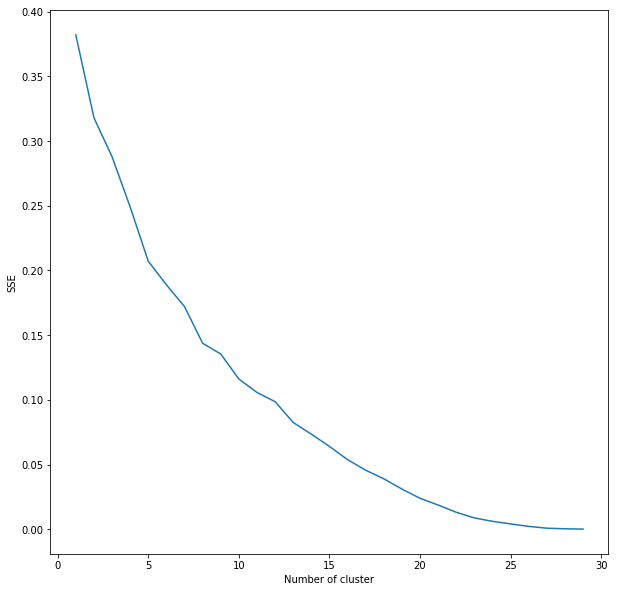

In [152]:
import matplotlib.pyplot as plt # to draw the graph

Clus=[] # define the list to store the number of clusters
Cost=[] # define the list to store the cost of clustering

# set number of clusters
kclusters = 30

for i in range(1,kclusters):
    Hospital_grouped_clustering = Hospital_grouped.drop('Hospital', 1)
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Hospital_grouped_clustering)
    
    # check cluster labels generated for each row in the dataframe
    labels=kmeans.labels_[0:34] 
    
    # check the cost of clustering. Sum of distances of samples to their closest cluster center
    interia = kmeans.inertia_
    
    Clus.append(i)
    Cost.append(interia)


plt.figure(figsize=(10, 10))
plt.plot(Clus,Cost)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

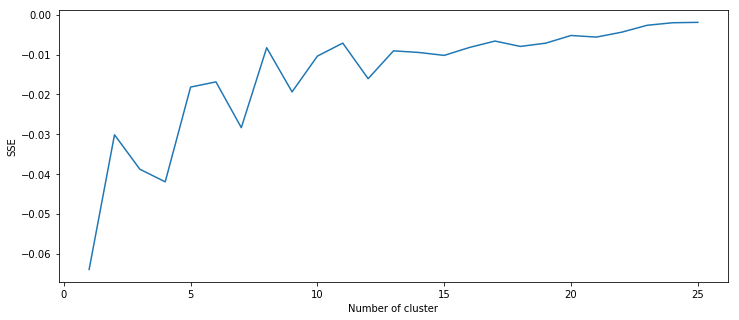

In [153]:
# visualizing the rate of fall of cost
cost_diff=[] #create the list to store cost difference value

for i in range(len(Cost)-1):
    diff=Cost[i+1]-Cost[i]
    cost_diff.append(diff)

plt.figure(figsize=(12, 5))
plt.plot(Clus[:25],cost_diff[:25])
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [154]:
# set number of clusters
kclusters = 3 # since rate of reduction of cost start stabilizing after k =3

Hospital_grouped_clustering = Hospital_grouped.drop('Hospital', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Hospital_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 


array([0, 0, 2, 1, 1, 1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 2, 1, 0, 1, 2, 1, 0, 2, 0], dtype=int32)

In [155]:
kmeans.cluster_centers_.shape

(3, 180)

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each hospital locality.

In [156]:
Hospital_merged = hospital

# add clustering labels
Hospital_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with 'hospital' to add latitude/longitude for each hospital locality
Hospital_merged = Hospital_merged.join(Hospital_venues_sorted.set_index('Hospital'), on='Hospital')

Hospital_merged.head() # check the last columns!

,Hospital,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Medanta Hospital, Gurugram, Haryana",28.4351,77.0404,0,Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,Shopping Mall,American Restaurant,Sandwich Place
1,"Apollo Hospital, Hyderabad, Telangana",17.4308,78.4103,0,Indian Restaurant,Bakery,Ice Cream Shop,Hotel,Café,Italian Restaurant,Restaurant,BBQ Joint,Lounge,Coffee Shop
2,Rabindranath Tagore International Institute of...,22.4956,88.3984,2,Hotel,Chinese Restaurant,Café,Mughlai Restaurant,Dhaba,Coffee Shop,Shopping Mall,Italian Restaurant,Indian Sweet Shop,Indian Restaurant
3,"Narayana Health, Bengaluru, Karnataka",12.9127,77.638,1,Ice Cream Shop,Indian Restaurant,Brewery,Café,Hotel,Pub,Burger Joint,Lounge,Breakfast Spot,Dessert Shop
4,"Continental Hospital, Hyderabad, Telangana",17.4436,78.352,1,Indian Restaurant,Hotel,Restaurant,Ice Cream Shop,Lounge,Coffee Shop,Café,Italian Restaurant,BBQ Joint,Bakery


Finally, let's visualize the resulting clusters

In [179]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hospital['latitude'], hospital['longitude'], Hospital_merged['Hospital'], Hospital_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Step 2f: Cluster Center identification and analysis
### Let's create a new dataframe that includes the cluster center features (i.e., top 10 venues category) associated with each cluster.

In [160]:
# create colnames 
colnames=Hospital_grouped.columns[1:]

# create cluster center dataframe containing value for each category
kclust=pd.DataFrame(kmeans.cluster_centers_, columns=colnames)
idx = 0
new_col = [0, 1, 2] # can be a list, a Series, an array or a scalar   
kclust.insert(loc=idx, column='Cluster_center', value=new_col) #insert cluster center as one of the columns at teh start of data frame
kclust.head()

,Cluster_center,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burmese Restaurant,Café,Chaat Place,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,Comfort Food Restaurant,Concert Hall,Convenience Store,Coworking Space,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hindu Temple,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kerala Restaurant,Korean Restaurant,Lake,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Optical Shop,Outdoor Sculpture,Park,Parsi Restaurant,Performing Arts Venue,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,0,1.538462e-03,0.001538,1.098901e-03,0.007692,7.692308e-04,0.000769,0.000000,0.014505,0.003077,0.001538,0.000000,0.021099,0.000000,0.039890,0.012637,9.230769e-03,7.692308e-04,0.002308,0.000000,0.006923,0.006154,7.692308e-04,1.084202e-19,0.002308,0.007692,0.007692,0.014066,-3.252607e-19,0.040989,3.076923e-03,5.421011e-20,0.022637,3.076923e-03,7.692308e-04,3.846154e-03,0.018352,5.421011e-20,0.004615,0.028791,5.421011e-20,1.084202e-19,0.000769,3.076923e-03,0.000769,7.692308e-04,0.001538,0.005385,0.007692,0.009560,0.009890,-4.336809e-19,2.168404e-19,0.012198,0.005385,0.001538,3.406593e-03,5.421011e-20,2.168404e-19,-8.673617e-19,1.084202e-19,1.084202e-19,0.016374,0.000000,2.307692e-03,7.692308e-04,0.000769,0.000769,1.098901e-03,5.421011e-20,0.004615,0.003077,4.336809e-19,0.000000,0.000769,-3.252607e-19,0.003846,2.168404e-19,7.692308e-04,0.005385,0.001538,2.168404e-19,0.000000,5.421011e-20,4.615385e-03,0.000769,4.615385e-03,0.067912,4.615385e-03,6.153846e-03,0.045604,0.138022,0.000769,0.000769,0.000000e+00,0.001538,0.026044,1.538462e-03,0.003077,2.307692e-03,1.725275e-02,0.001538,0.001538,0.001538,1.538462e-03,0.001538,0.013077,5.421011e-20,8.673617e-19,0.002308,0.003846,0.000769,0.006154,5.421011e-20,3.846154e-03,0.000769,0.000769,2.307692e-03,1.084202e-19,0.004945,0.000769,0.003846,0.030659,5.421011e-20,5.421011e-20,0.006484,0.004176,1.098901e-03,5.421011e-20,0.009560,1.538462e-03,3.846154e-03

In [161]:
# creating a data frame containing cluster center and top 10 venue category for each cluster center

num_top_venues = 10

# create columns according to number of top venues
columns = ['Cluster_center']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Cluster_center_sorted = pd.DataFrame(columns=columns)
Cluster_center_sorted['Cluster_center'] = kclust['Cluster_center']

for ind in np.arange(kclust.shape[0]):
    Cluster_center_sorted.iloc[ind, 1:] = return_most_common_venues(kclust.iloc[ind, :], num_top_venues)

Cluster_center_sorted

,Cluster_center,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Indian Restaurant,Hotel,Ice Cream Shop,Café,Bakery,Multiplex,Coffee Shop,Italian Restaurant,Restaurant,Chinese Restaurant
1,1,Indian Restaurant,Café,Hotel,Coffee Shop,Ice Cream Shop,Bakery,Dessert Shop,Lounge,Restaurant,Italian Restaurant
2,2,Hotel,Indian Restaurant,Café,Coffee Shop,Brewery,Shopping Mall,Chinese Restaurant,Italian Restaurant,Bakery,Mughlai Restaurant


### Cluster 0: Food and Entertainment

In [168]:
Hospital_merged.loc[Hospital_merged['Cluster Labels'] == 0, Hospital_merged.columns[[0] + list(range(4, Hospital_merged.shape[1]))]]

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Medanta Hospital, Gurugram, Haryana",Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,Shopping Mall,American Restaurant,Sandwich Place
1,"Apollo Hospital, Hyderabad, Telangana",Indian Restaurant,Bakery,Ice Cream Shop,Hotel,Café,Italian Restaurant,Restaurant,BBQ Joint,Lounge,Coffee Shop
10,"Global Hospital, Hyderabad, Telangana",Indian Restaurant,Bakery,Hotel,Ice Cream Shop,Coffee Shop,Multiplex,Restaurant,Diner,Café,Asian Restaurant
12,"Bombay Hospital, Mumbai, Maharashtra",Indian Restaurant,Café,Ice Cream Shop,Fast Food Restaurant,Hotel,Scenic Lookout,History Museum,Japanese Restaurant,Juice Bar,Lounge
13,"S.L. Raheja (A fortis Associate) Hospital, Mum...",Indian Restaurant,Café,Bakery,Dessert Shop,Seafood Restaurant,Bar,Deli / Bodega,Lounge,Coffee Shop,Scenic Lookout
14,"Dr. Balabhai Nanavati Hospital, Mumbai, Mahara...",Indian Restaurant,Hotel,Café,Coffee Shop,Ice Cream Shop,Dessert Shop,Bar,Lounge,Seafood Restaurant,Pub
15,"P.D. Hinduja National Hospital, Mumbai, Mahara...",Indian Restaurant,Café,Bakery,Dessert Shop,Seafood Restaurant,Bar,Deli / Bodega,Lounge,Coffee Shop,Scenic Lookout
18,"SIMS Hospital, Chennai, Tamil Nadu",Indian Restaurant,Hotel,Ice Cream Shop,Sandwich Place,Multiplex,Clothing Store,Café,Bar,Italian Restaurant,BBQ Joint
19,Madras Institute of Orthopedics and Traumatolo...,Indian Restaurant,Hotel,Clothing Store,Ice Cream Shop,Sandwich Place,Café,South Indian Restaurant,Italian Restaurant,Coffee Shop,Chinese Restaurant
21,"Indraprastha Apollo Hospital, New Delhi, Delhi",Indian Restaurant,Café,Coffee Shop,Market,Restaurant,Hotel,Shopping Mall,Lounge,Bakery,Stadium


### Cluster 1: Food and Relaxation

In [169]:
Hospital_merged.loc[Hospital_merged['Cluster Labels'] == 1, Hospital_merged.columns[[0] + list(range(4, Hospital_merged.shape[1]))]]

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Narayana Health, Bengaluru, Karnataka",Ice Cream Shop,Indian Restaurant,Brewery,Café,Hotel,Pub,Burger Joint,Lounge,Breakfast Spot,Dessert Shop
4,"Continental Hospital, Hyderabad, Telangana",Indian Restaurant,Hotel,Restaurant,Ice Cream Shop,Lounge,Coffee Shop,Café,Italian Restaurant,BBQ Joint,Bakery
5,"Max Hospital, New Delhi, Delhi",Coffee Shop,Café,Italian Restaurant,Indian Restaurant,Asian Restaurant,Shopping Mall,Market,Lounge,Clothing Store,Thai Restaurant
6,"Fortis Flt. Lt. Rajan Dhall Hospital, New Delh...",Hotel,Indian Restaurant,Italian Restaurant,Shopping Mall,Coffee Shop,Café,American Restaurant,Restaurant,Asian Restaurant,Thai Restaurant
9,"Global Hospital, Chennai, Tamil Nadu",Indian Restaurant,Pizza Place,Multiplex,Fast Food Restaurant,Coffee Shop,Sandwich Place,Hotel,Café,Clothing Store,Donut Shop
16,"MGM Hospital, Navi Mumbai, Maharashtra",Indian Restaurant,Fast Food Restaurant,Restaurant,Café,Coffee Shop,Chinese Restaurant,Ice Cream Shop,Diner,Lounge,Asian Restaurant
17,"Kohinoor Hospital, Mumbai, Maharashtra",Indian Restaurant,Hotel,Dessert Shop,Bar,Deli / Bodega,Coffee Shop,Bakery,Café,Seafood Restaurant,Snack Place
20,"Fortis Hospital, Kolkata, West Bengal",Hotel,Chinese Restaurant,Café,Mughlai Restaurant,Shopping Mall,Indian Restaurant,Multiplex,Coffee Shop,Dhaba,Italian Restaurant
22,"HCG Hospital, Bengaluru, Karnataka",Indian Restaurant,Hotel,Pub,Bakery,Brewery,Ice Cream Shop,Lounge,Burger Joint,Italian Restaurant,Dessert Shop
24,"The Calcutta Medical Research Institute, Kolka...",Café,Hotel,Mughlai Restaurant,Chinese Restaurant,Indian Restaurant,Shopping Mall,Multiplex,Indian Sweet Shop,Pub,Dhaba


### Cluster 2: Food, Shopping and Alcoholic Beverages

In [170]:
Hospital_merged.loc[Hospital_merged['Cluster Labels'] == 2, Hospital_merged.columns[[0] + list(range(4, Hospital_merged.shape[1]))]]

,Hospital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Rabindranath Tagore International Institute of...,Hotel,Chinese Restaurant,Café,Mughlai Restaurant,Dhaba,Coffee Shop,Shopping Mall,Italian Restaurant,Indian Sweet Shop,Indian Restaurant
7,"Artemis Hospital, Gurugram, Haryana",Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,American Restaurant,Shopping Mall,Restaurant
8,"Apollo Hospital, Chennai, Tamil Nadu",Indian Restaurant,Hotel,Ice Cream Shop,Juice Bar,Café,Sandwich Place,BBQ Joint,Multiplex,Coffee Shop,Vegetarian / Vegan Restaurant
11,"Yashoda Hospital, Hyderabad, Telangana",Indian Restaurant,Hotel,Bakery,Multiplex,Ice Cream Shop,Restaurant,Hyderabadi Restaurant,Coffee Shop,Chinese Restaurant,Fast Food Restaurant
23,"Omega Hospital, Hyderabad, Telangana",Indian Restaurant,Bakery,Hotel,Ice Cream Shop,Coffee Shop,Café,Multiplex,Lounge,BBQ Joint,Restaurant
27,"Kokilaben Dhirubhai Ambani Hospital, Mumbai, M...",Indian Restaurant,Café,Hotel,Ice Cream Shop,Bakery,Coffee Shop,Chinese Restaurant,Pub,Multiplex,Beach
30,"Fortis Memorial Research Institute, Gurugram, ...",Indian Restaurant,Hotel,Brewery,Café,Coffee Shop,Bar,Bakery,American Restaurant,Shopping Mall,Restaurant
